In [ ]:
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

In [ ]:
'''
Geographic Weighted Regression Model for Leukemia in Floria Counties applying pysal GWR libraries
Dependent Variable: Leukemia Incidence per 100,000 people
Independent Variables:
obs_pct : percent of population that is obese 2019 FL Health Survey
Percent_sm: percent of adult populations who are smokers 2019 FL Health Survey
PCT_ATRISK: Percent of populations between 0-15 and 65+
pesticide_: Percent of land cover per county with probable pesticide use
hydro_pct: Percent of land cover per county of hydrocarbon and other power infrastructure
uploading to github for convenient jupyter notebook output support
'''
fl_counties = gp.read_file('E:\\fl_leuk\\leukemia_fl.shp')
fl_counties.head()
fl_y = fl_counties['INCIDENCE_'].values.reshape((-1,1)) #leukemia incidence per 100,000
fl_x = fl_counties[["obs_pct", "Percent_sm", "PCT_ATRISK", "pesticide_", "hydro_pct"]].values 

coord_x = fl_counties['cen_x']
coord_y = fl_counties['cen_y']
centroid_coords = list(zip(coord_x,coord_y))
#normalize independent variables
fl_x = (fl_x - fl_x.mean(axis=0)) / fl_x.std(axis=0)
fl_y = fl_y.reshape((-1,1))
fl_y = (fl_y- fl_y.mean(axis=0)) / fl_y.std(axis=0)


In [5]:
gwr_selector = Sel_BW(centroid_coords, fl_y, fl_x)
gwr_bw = gwr_selector.search(multi_bw_min=[2])
print(gwr_bw)
gwr_results = GWR(centroid_coords, fl_y, fl_x, gwr_bw).fit()

66.0


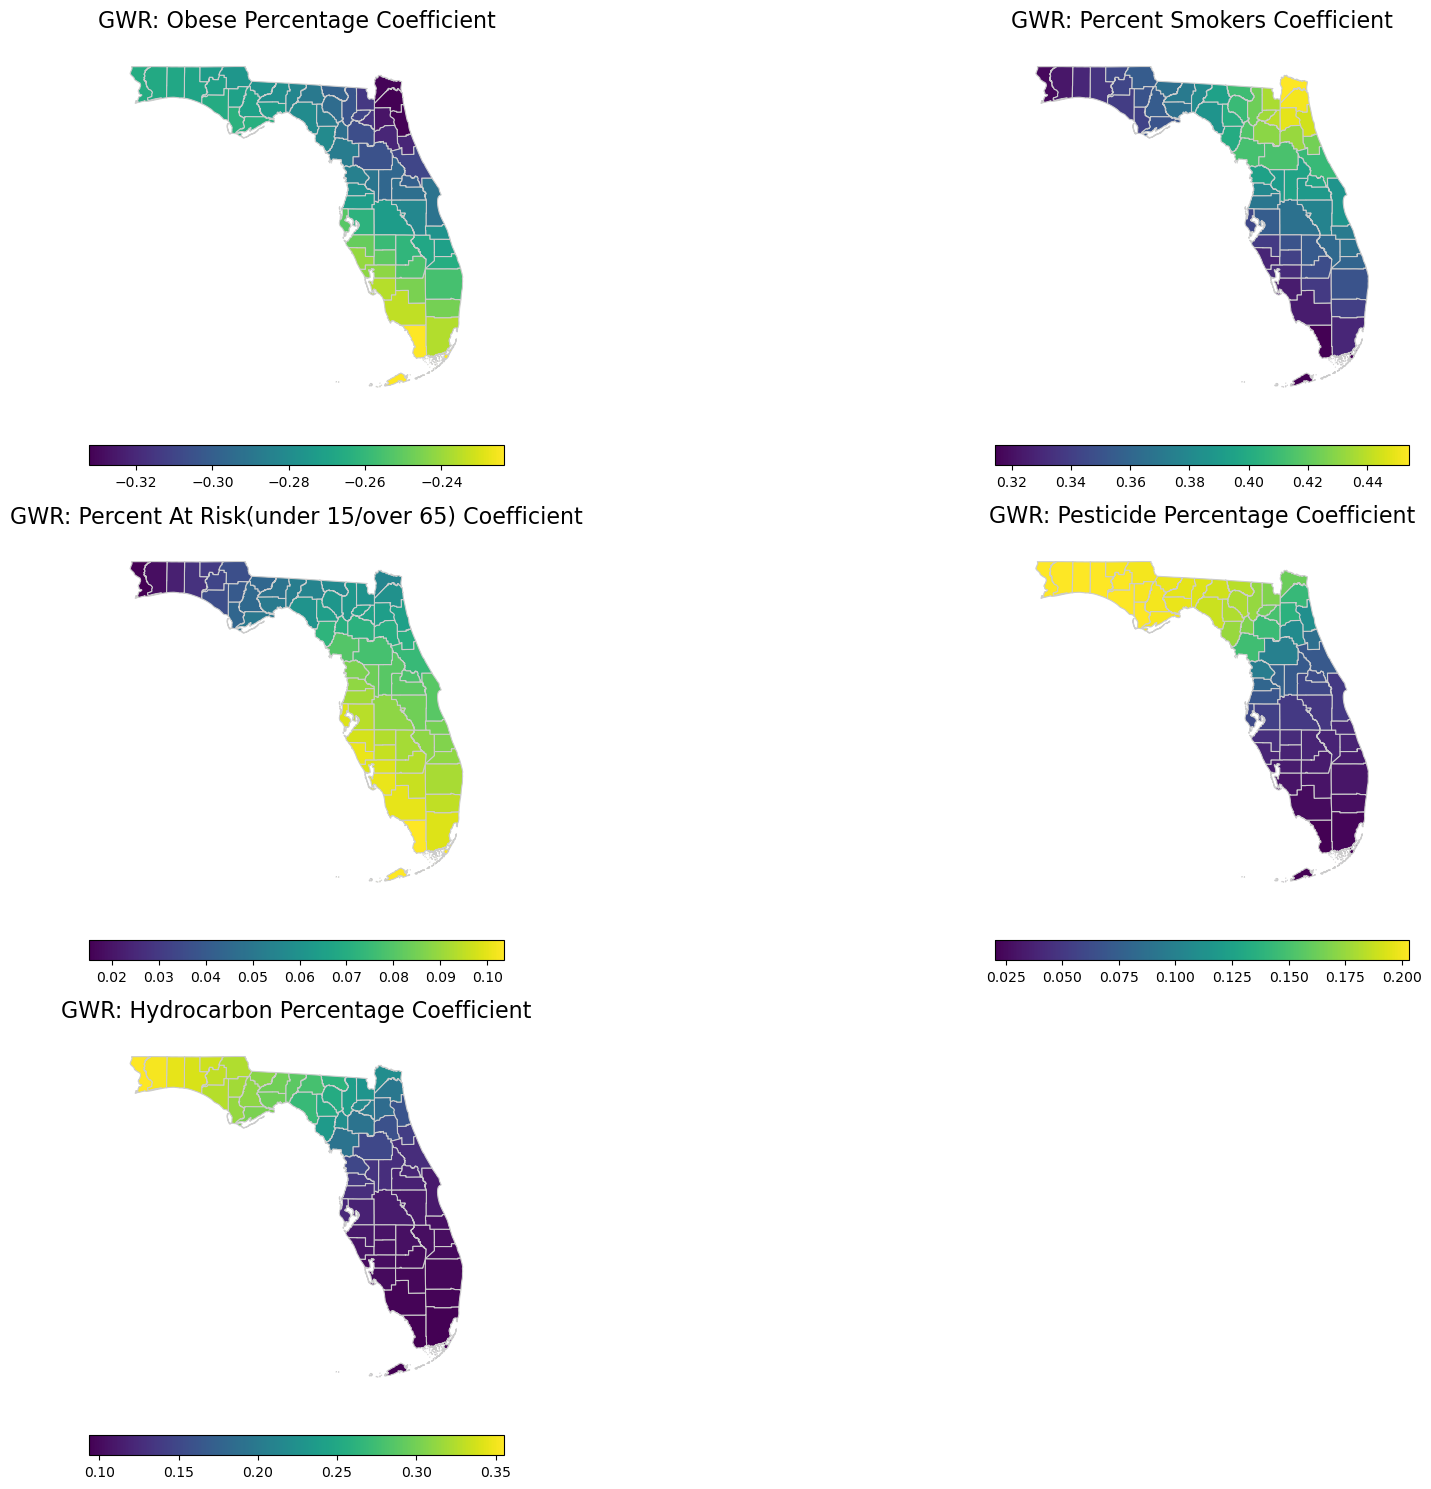

<Figure size 640x480 with 0 Axes>

In [13]:

# Coefficients and relevant 
fl_counties['co_intercept'] = gwr_results.params[:, 0]
fl_counties['co_obs_pct'] = gwr_results.params[:, 1]
fl_counties['co_percent_smokers'] = gwr_results.params[:, 2]
fl_counties['co_pct_atrisk'] = gwr_results.params[:, 3]
fl_counties['co_pesticide_pct'] = gwr_results.params[:, 4]
fl_counties['co_hydro_pct'] = gwr_results.params[:, 5]
fl_counties['residuals'] = gwr_results.std_res
fl_counties['local_r2'] = gwr_results.localR2

variables = [
    ('co_obs_pct', 'GWR: Obese Percentage Coefficient'),
    ('co_percent_smokers', 'GWR: Percent Smokers Coefficient'),
    ('co_pct_atrisk', 'GWR: Percent At Risk(under 15/over 65) Coefficient'),
    ('co_pesticide_pct', 'GWR: Pesticide Percentage Coefficient'),
    ('co_hydro_pct', 'GWR: Hydrocarbon Percentage Coefficient')
]
num_vars = len(variables)
num_cols = 2
num_rows = (num_vars + 1) // 2  # Ceiling division to ensure enough rows
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5*num_rows))
axes = axes.flatten()

for i, (col, title) in enumerate(variables):
    ax = axes[i]
    ax.set_title(title, fontsize=16)
    cmap = plt.cm.viridis
    vmin = fl_counties[col].min()
    vmax = fl_counties[col].max()
    fl_counties.plot(column=col, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', vmin=vmin, vmax=vmax)
    ax.set_axis_off()
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.05, pad=0.1)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

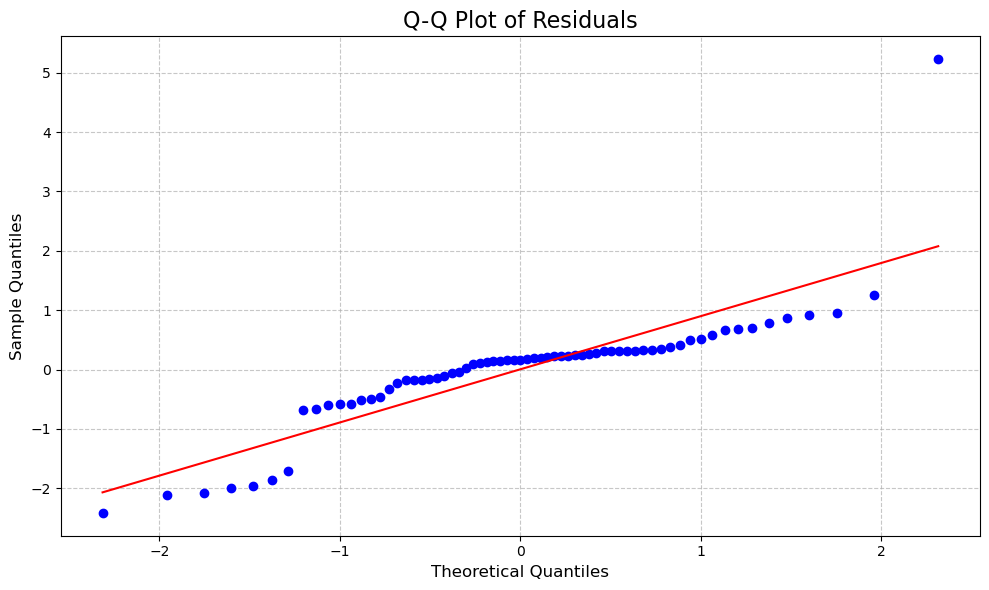

In [15]:
residuals = fl_counties['residuals']
import scipy.stats as stats 
# Create Q-Q Plot
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals', fontsize=16)
plt.xlabel('Theoretical Quantiles', fontsize=12)
plt.ylabel('Sample Quantiles', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()